In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

# for constant figure size
BIG_FIG = (15,5)

import pmdarima as pm
from fbprophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Data information

This data is for the $\texttt{rtfpna}$ for three countries (USA, CAN, MEX) 

rtfpna is composed by: Relative levels of income, output, inputs, productivity.
All the data is relative to the year of 2005

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/eduardo-vicentini/challenge/master/TFP.csv")

# Exploratory Data Analysis

In [ ]:
data.head()

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179


In [ ]:
usa = data.loc[data["isocode"] == 'USA']
can = data.loc[data["isocode"] == 'CAN']
mex = data.loc[data["isocode"] == 'MEX']

In [ ]:
# Don't need the index for the country specif neither the country name
def drop_set(dfs):
    for df in dfs:
        df.drop(['isocode'], axis=1, inplace=True)
        df.set_index('year', inplace=True)

drop_set([usa, can, mex])

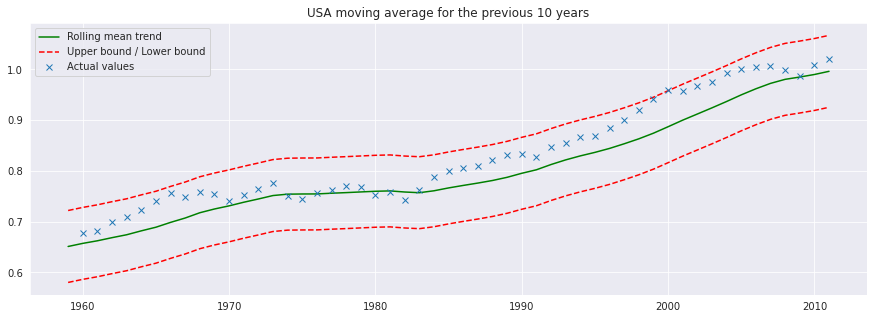

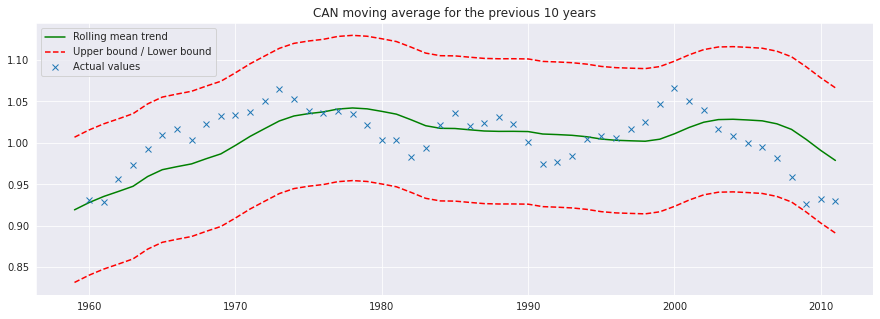

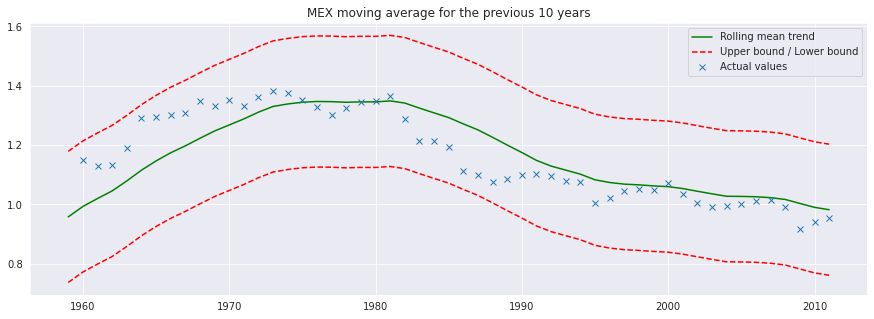

In [ ]:
def plot_moving_average(series, window, country, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=BIG_FIG)
    plt.title(f"{country} moving average for the previous {window} years")
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], 'x', label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)


plot_moving_average(usa, 10, 'USA', plot_intervals=True)

plot_moving_average(can, 10, 'CAN', plot_intervals=True)

plot_moving_average(mex, 10, 'MEX', plot_intervals=True)

The trend for the USA is obviously upwards. The moving averages was not needed to see this.

To CAN, the rtfpna was not really changing that much. However, now it has a lowering trend.

MEX has been downward since 1980.


## Dickey-Fuller test

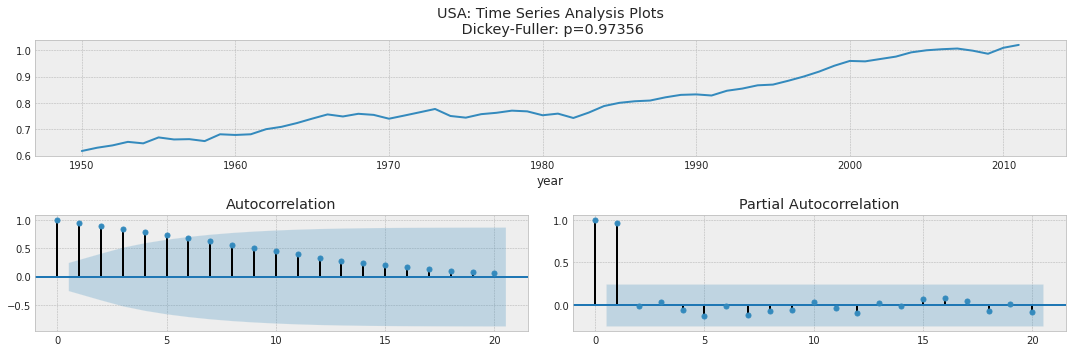

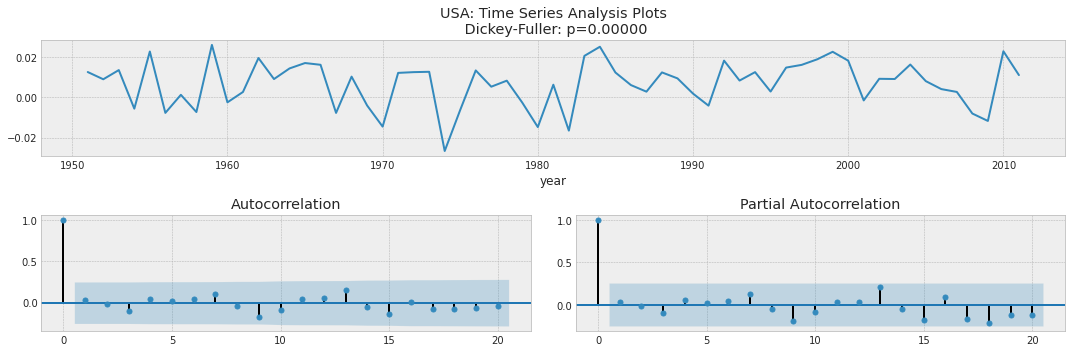

In [ ]:
def tsplot(y, lags=None, figsize=BIG_FIG, syle='bmh', con=None):
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('{0:}: Time Series Analysis Plots\n Dickey-Fuller: p={1:.5f}'.format(con, p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(usa.rtfpna, lags=20, con="USA")

usa_diff = usa.rtfpna - usa.rtfpna.shift(1)

tsplot(usa_diff[1:], lags=20, con="USA")

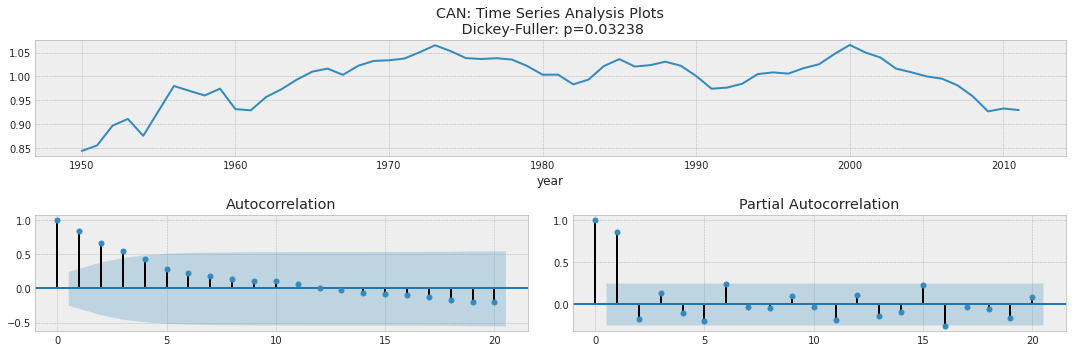

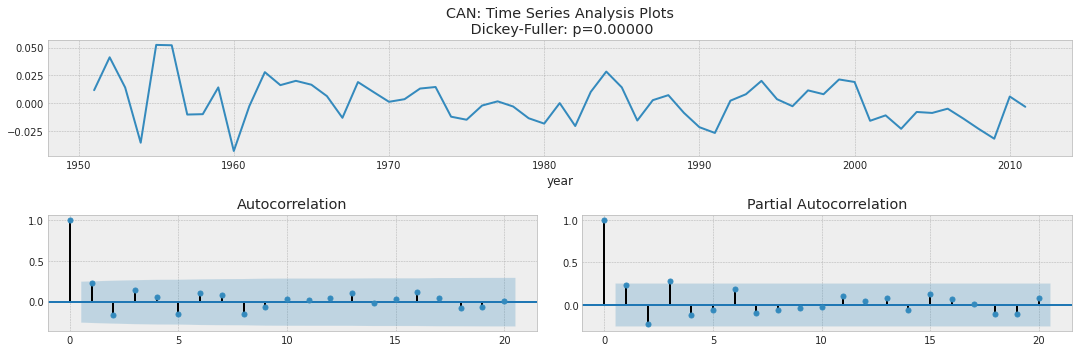

In [ ]:
tsplot(can.rtfpna, lags=20, con="CAN")

can_diff = can.rtfpna - can.rtfpna.shift(1)
tsplot(can_diff[1:], lags=20, con="CAN")

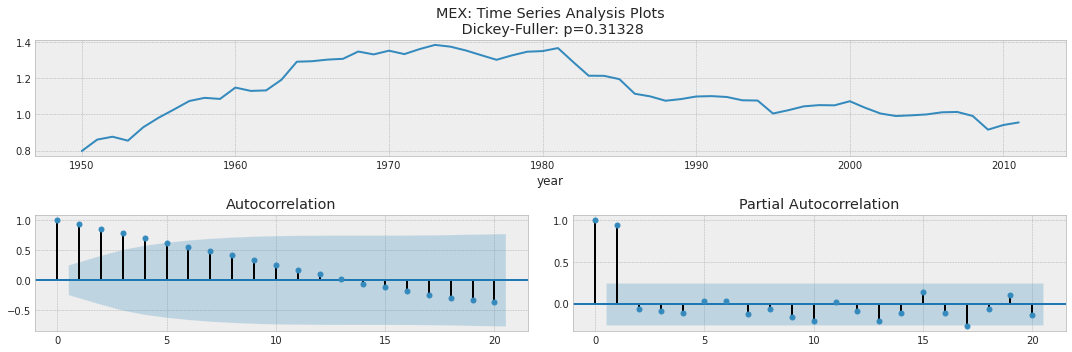

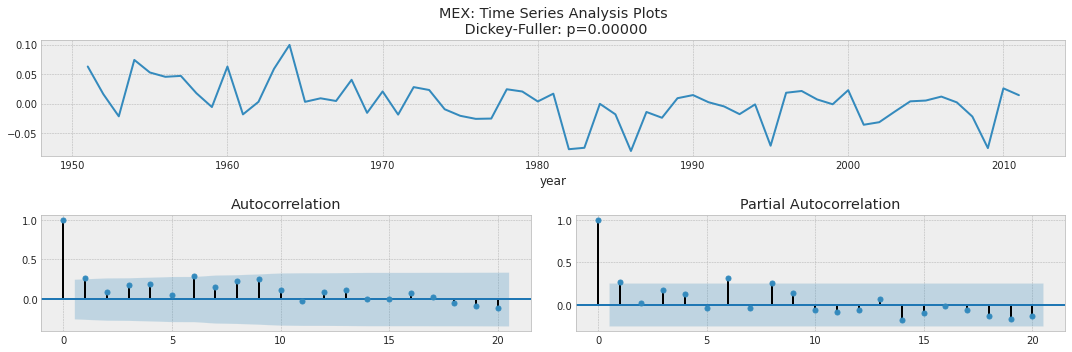

In [ ]:
tsplot(mex.rtfpna, lags=20, con="MEX")

mex_diff = mex.rtfpna - mex.rtfpna.shift(1)
tsplot(mex_diff[1:], lags=20, con="MEX")

In the Dickey-Fuller test for the Canada, it is possible to see the stationarity of the data

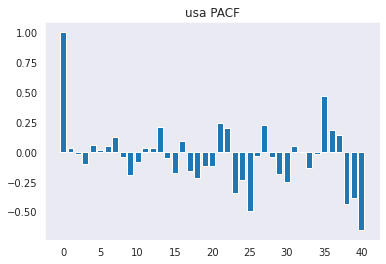

In [ ]:
pacf_vals = pacf(usa_diff[1:])
num_lags = 41
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title("usa PACF")
plt.show()

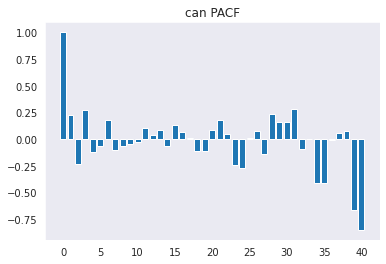

In [ ]:

pacf_vals = pacf(can_diff[1:])
num_lags = 41
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title("can PACF")
plt.show()

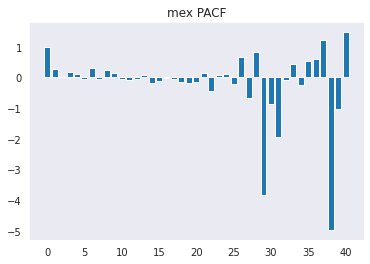

In [ ]:

pacf_vals = pacf(mex_diff[1:])
num_lags = 41
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title("mex PACF")
plt.show()

PACF sugests a seasonality of 10 for the usa.


## ARIMA Model

In [ ]:
stepwise_fit_usa = pm.auto_arima(usa, start_p=0, start_q=10,
                             max_p=11, max_q=11, m=10, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit_usa.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,9)x(1,1,1,10) [intercept=True]; AIC=-262.991, BIC=-237.877, Time=2.793 seconds
Fit ARIMA(0,1,0)x(0,1,0,10) [intercept=True]; AIC=-267.538, BIC=-263.675, Time=0.072 seconds
Fit ARIMA(1,1,0)x(1,1,0,10) [intercept=True]; AIC=-276.815, BIC=-269.088, Time=0.934 seconds
Fit ARIMA(0,1,1)x(0,1,1,10) [intercept=True]; AIC=-281.389, BIC=-273.662, Time=1.592 seconds
Fit ARIMA(0,1,0)x(0,1,0,10) [intercept=False]; AIC=-269.538, BIC=-267.606, Time=0.075 seconds
Fit ARIMA(0,1,1)x(0,1,0,10) [intercept=True]; AIC=-266.538, BIC=-260.743, Time=0.310 seconds
Fit ARIMA(0,1,1)x(1,1,1,10) [intercept=True]; AIC=-279.554, BIC=-269.895, Time=1.208 seconds
Fit ARIMA(0,1,1)x(0,1,2,10) [intercept=True]; AIC=-279.570, BIC=-269.911, Time=2.109 seconds
Fit ARIMA(0,1,1)x(1,1,0,10) [intercept=True]; AIC=-276.803, BIC=-269.076, Time=1.128 seconds
Fit ARIMA(0,1,1)x(1,1,2,10) [intercept=True]; AIC=-277.478, BIC=-265.887, Time=2.205 seconds
Fit ARIMA(0,1,0)x(0,1,1,10

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   62
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 10)   Log Likelihood                 144.692
Date:                              Wed, 08 Jul 2020   AIC                           -283.385
Time:                                      16:24:08   BIC                           -277.589
Sample:                                           0   HQIC                          -281.170
                                               - 62                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.650      0.516      -0.001       0.003
ma.S.L10      -0.7750      0.300     -2.583      0.010      -1.363      -0.187
sigma2         0.0002   5.11e-05      3.312      0.001     6.9e-05       0.000
===================================================================================
Ljung-Box (Q):                       39.89   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.47   Prob(JB):                         0.70
Heteroskedasticity (H):               0.87   Skew:                            -0.29
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
stepwise_fit_can = pm.auto_arima(can, start_p=1, start_q=1,
                             max_p=11, max_q=11, m=1, seasonal=False,
                             d=0, D=0, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit_can.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-313.079, BIC=-304.570, Time=0.192 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-192.219, BIC=-187.965, Time=0.032 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-307.468, BIC=-301.086, Time=0.133 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-252.212, BIC=-245.831, Time=0.104 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=177.218, BIC=179.345, Time=0.016 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-311.115, BIC=-300.479, Time=0.300 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=-312.425, BIC=-301.789, Time=0.263 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=-285.042, BIC=-276.533, Time=0.105 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=-309.462, BIC=-300.954, Time=0.266 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-310.047, BIC=-297.284, Time=0.177 seconds
Total fit time: 1.598 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 160.540
Date:                Wed, 08 Jul 2020   AIC                           -313.079
Time:                        16:24:09   BIC                           -304.570
Sample:                             0   HQIC                          -309.738
                                 - 62                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0835      0.055      1.523      0.128      -0.024       0.191
ar.L1          0.9134      0.059     15.612      0.000       0.799       1.028
ma.L1          0.4773      0.124      3.842      0.000       0.234       0.721
sigma2         0.0003   4.93e-05      6.391      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       35.36   Jarque-Bera (JB):                 7.38
Prob(Q):                              0.68   Prob(JB):                         0.03
Heteroskedasticity (H):               0.31   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
stepwise_fit_mex = pm.auto_arima(mex, start_p=1, start_q=1,
                             max_p=11, max_q=11, m=5, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit_mex.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,5) [intercept=True]; AIC=-197.305, BIC=-185.153, Time=0.724 seconds
Fit ARIMA(0,1,0)x(0,1,0,5) [intercept=True]; AIC=-177.930, BIC=-173.879, Time=0.036 seconds
Fit ARIMA(1,1,0)x(1,1,0,5) [intercept=True]; AIC=-193.262, BIC=-185.161, Time=0.227 seconds
Fit ARIMA(0,1,1)x(0,1,1,5) [intercept=True]; AIC=-201.619, BIC=-193.517, Time=0.407 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,0)x(0,1,0,5) [intercept=False]; AIC=-179.480, BIC=-177.455, Time=0.046 seconds
Fit ARIMA(1,1,1)x(0,1,1,5) [intercept=True]; AIC=-199.855, BIC=-189.728, Time=0.669 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,0,5) [intercept=True]; AIC=-190.790, BIC=-180.663, Time=0.281 seco

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   62
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 5)   Log Likelihood                 104.809
Date:                           Wed, 08 Jul 2020   AIC                           -201.619
Time:                                   16:24:28   BIC                           -193.517
Sample:                                        0   HQIC                          -198.478
                                            - 62                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0042      0.002     -2.345      0.019      -0.008      -0.001
ma.L1          0.1589      0.121      1.308      0.191      -0.079       0.397
ma.S.L5       -0.9966     11.977     -0.083      0.934     -24.471      22.477
sigma2         0.0011      0.013      0.084      0.933      -0.025       0.027
===================================================================================
Ljung-Box (Q):                       32.30   Jarque-Bera (JB):                 2.63
Prob(Q):                              0.80   Prob(JB):                         0.27
Heteroskedasticity (H):               0.84   Skew:                            -0.45
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Mean Error = 0.94%


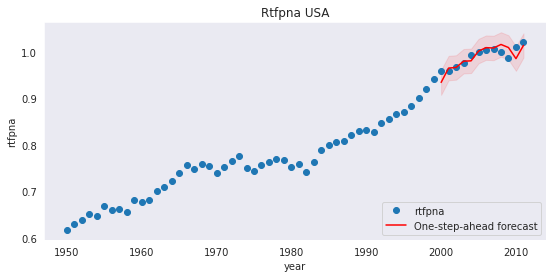

In [ ]:
p, d, q , P, D, Q, s = (0, 1, 0, 0, 1, 1, 10)
mod = sm.tsa.statespace.SARIMAX(usa, order=(p, d, q), enforce_stationarity=False,
                                       seasonal_order=(P, D, Q, s))

usa_best_model = mod.fit(disp=-1)

res_usa = mod.filter(usa_best_model.params)

# Dynamic predictions
predict = res_usa.get_prediction()
predict_ci = predict.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Rtfpna USA', xlabel='Date', ylabel='rtfpna')

# Plot data points
usa.plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc[2000:].plot(ax=ax, style='r-', label='One-step-ahead forecast')
ci = predict_ci.loc[2000:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower right')

# Make a dataframe containing actual and predicted prices
comparison = pd.DataFrame({'actual': usa.loc[2002:].rtfpna,
                          'predicted': predict.predicted_mean.loc[2002:]}, 
                          index = usa.loc[2002:].index)
print('Mean Error = %.2f%%' % mean_absolute_percentage_error(comparison.actual, comparison.predicted))

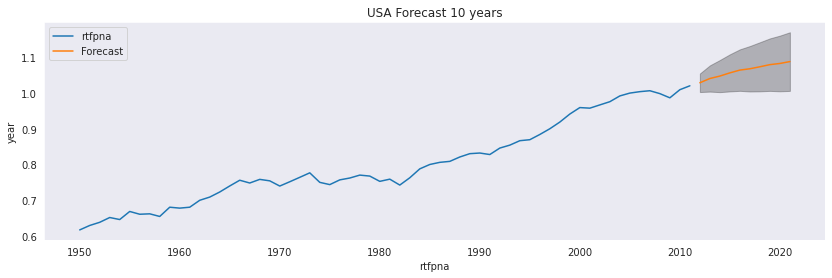

In [ ]:


pred_uc = res_usa.get_forecast(10)
pred_ci = pred_uc.conf_int()

pred = pred_uc.predicted_mean
res_year_usa = []
res_value_usa = []

for i in range(1, len(pred) + 1):
    index = i
    index += usa.index[-1]
    res_year_usa.append(index)
    res_value_usa.append(pred.values[i - 1])

ax = usa.plot(label='observed', figsize=(14, 4))
plt.plot(res_year_usa, res_value_usa, label='Forecast')
ax.fill_between(res_year_usa,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('rtfpna')
ax.set_ylabel('year')
plt.legend(loc='upper left')
plt.title("USA Forecast 10 years")
plt.show()

Mean Error = 1.30%


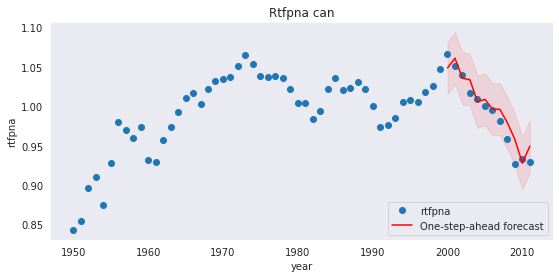

In [ ]:
p, d, q = (1, 0, 1)
mod = statsmodels.tsa.arima.model.ARIMA(can, order=(p, d, q), enforce_stationarity=False)


can_best_model = mod.fit()

res_can = mod.filter(can_best_model.params)

# Dynamic predictions
predict = res_can.get_prediction()
predict_ci = predict.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Rtfpna can', xlabel='Date', ylabel='rtfpna')

# Plot data points
can.plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc[2000:].plot(ax=ax, style='r-', label='One-step-ahead forecast')
ci = predict_ci.loc[2000:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower right')

# Make a dataframe containing actual and predicted prices
comparison = pd.DataFrame({'actual': can.loc[2002:].rtfpna,
                          'predicted': predict.predicted_mean.loc[2002:]}, 
                          index = can.loc[2002:].index)
print('Mean Error = %.2f%%' % mean_absolute_percentage_error(comparison.actual, comparison.predicted))

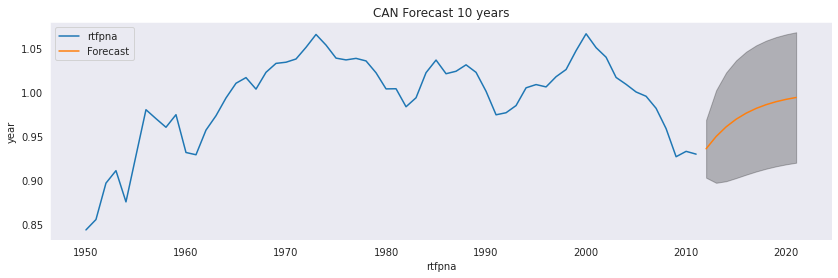

In [ ]:
pred_uc = res_can.get_forecast(10)
pred_ci = pred_uc.conf_int()

pred = pred_uc.predicted_mean
res_year_can = []
res_value_can = []

for i in range(1, len(pred) + 1):
    index = i
    index += can.index[-1]
    res_year_can.append(index)
    res_value_can.append(pred.values[i - 1])

ax = can.plot(label='observed', figsize=(14, 4))
plt.plot(res_year_can, res_value_can, label='Forecast')
ax.fill_between(res_year_can,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('rtfpna')
ax.set_ylabel('year')
plt.legend(loc='upper left')
plt.title("CAN Forecast 10 years")
plt.show()

Mean Error = 2.28%


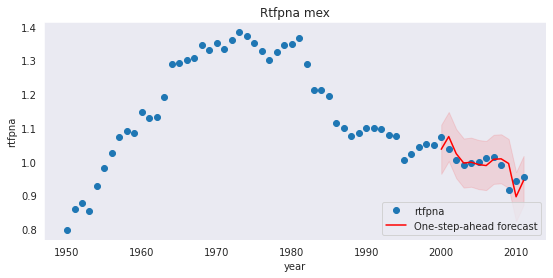

In [ ]:


p, d, q , P, D, Q, s = (0, 1, 1, 0, 1, 1, 5)
mod = sm.tsa.statespace.SARIMAX(mex, order=(p, d, q), enforce_stationarity=False,
                                       seasonal_order=(P, D, Q, s))
mex_best_model = mod.fit()

res_mex = mod.filter(mex_best_model.params)

# Dynamic predictions
predict = res_mex.get_prediction()
predict_ci = predict.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Rtfpna mex', xlabel='Date', ylabel='rtfpna')

# Plot data points
mex.plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc[2000:].plot(ax=ax, style='r-', label='One-step-ahead forecast')
ci = predict_ci.loc[2000:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower right')

# Make a dataframe containing actual and predicted prices
comparison = pd.DataFrame({'actual': mex.loc[2002:].rtfpna,
                          'predicted': predict.predicted_mean.loc[2002:]}, 
                          index = mex.loc[2002:].index)
print('Mean Error = %.2f%%' % mean_absolute_percentage_error(comparison.actual, comparison.predicted))

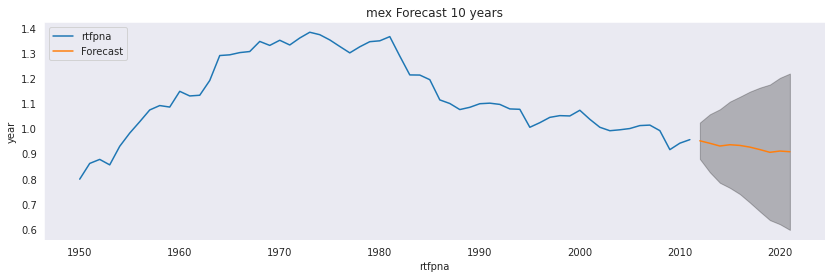

In [ ]:
pred_uc = res_mex.get_forecast(10)
pred_ci = pred_uc.conf_int()

pred = pred_uc.predicted_mean
res_year_mex = []
res_value_mex = []

for i in range(1, len(pred) + 1):
    index = i
    index += mex.index[-1]
    res_year_mex.append(index)
    res_value_mex.append(pred.values[i - 1])

ax = mex.plot(label='observed', figsize=(14, 4))
plt.plot(res_year_mex, res_value_mex, label='Forecast')
ax.fill_between(res_year_mex,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('rtfpna')
ax.set_ylabel('year')
plt.legend(loc='upper left')
plt.title("mex Forecast 10 years")
plt.show()

In [ ]:
def pred_rtfpna(values, years, con=None):
  print(f"Predictions for {con}:")
  for i, value in enumerate(values):
    print(f"{years[i]}: {value}")
  print()

In [ ]:
pred_rtfpna(res_value_usa, res_year_usa, con="USA")
pred_rtfpna(res_value_can, res_year_can, con="CAN")
pred_rtfpna(res_value_can, res_year_can, con="MEX")

Predictions for USA:
2012: 1.0288545141354426
2013: 1.0408111085951757
2014: 1.0476077394740824
2015: 1.0565655254477109
2016: 1.0643519333662257
2017: 1.0680522315623653
2018: 1.073593511461124
2019: 1.0795935086888044
2020: 1.082882945484226
2021: 1.0881651625300899

Predictions for CAN:
2012: 0.9355193952908363
2013: 0.9494200029287836
2014: 0.9603997903245259
2015: 0.9690724853890639
2016: 0.975922858440151
2017: 0.9813338189996829
2018: 0.9856078189641319
2019: 0.9889837585029871
2020: 0.9916503396599377
2021: 0.9937566140717757

Predictions for MEX:
2012: 0.9355193952908363
2013: 0.9494200029287836
2014: 0.9603997903245259
2015: 0.9690724853890639
2016: 0.975922858440151
2017: 0.9813338189996829
2018: 0.9856078189641319
2019: 0.9889837585029871
2020: 0.9916503396599377
2021: 0.9937566140717757



## FBProphet

In [ ]:
def split_train_test(df, test_size=5):
  df_train = df.iloc[:len(df) - test_size].copy()
  df_test = df.iloc[len(df) - test_size:].copy()

  return df_train, df_test

In [ ]:
usa_train, usa_test = split_train_test(usa)
# Setup and train model and fit
model = Prophet()
model.fit(usa_train.reset_index().rename(columns={'year':'ds', 'rtfpna':'y'}))

# Predict on training set with model
usa_test_fcst = model.predict(df=usa_test.reset_index() \
                                   .rename(columns={'year':'ds'}))

print("MAPE for the predictions on rtfpna for usa: %.2f%%" %mean_absolute_percentage_error(y_true=usa_test['rtfpna'].values,
                   y_pred=usa_test_fcst['yhat']))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for the predictions on rtfpna for usa: 4.31%


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


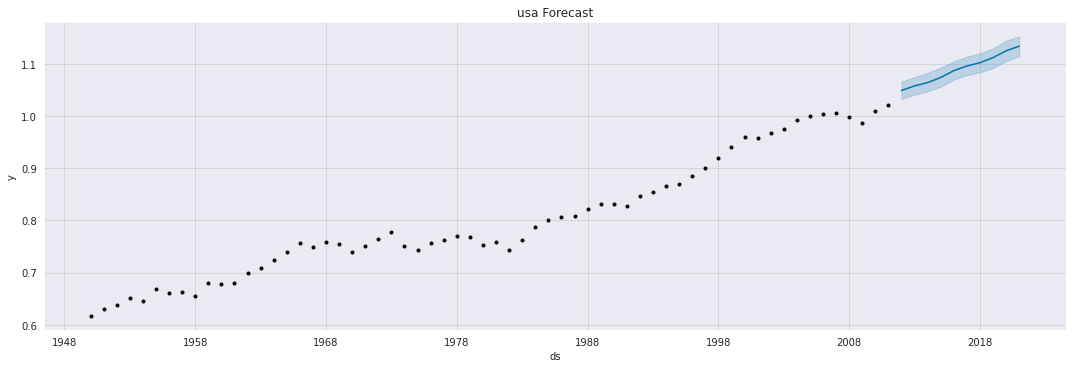

In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(usa.reset_index().rename(columns={'year':'ds', 'rtfpna':'y'}))
usa_fcst = pd.DataFrame(range(2012, 2022), columns=["ds"])
# Predict on training set with model
usa_fcst = model.predict(df=usa_fcst)
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(usa_fcst,
                 ax=ax)
plt.title("usa Forecast")
plt.show()

In [ ]:
usa_fcst[["ds", "yhat"]]

,ds,yhat
0,2012-01-01,1.048916
1,2013-01-01,1.057796
2,2014-01-01,1.064103
3,2015-01-01,1.073823
4,2016-01-01,1.086954
5,2017-01-01,1.095834
6,2018-01-01,1.102141
7,2019-01-01,1.111861
8,2020-01-01,1.124992
9,2021-01-01,1.133872


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


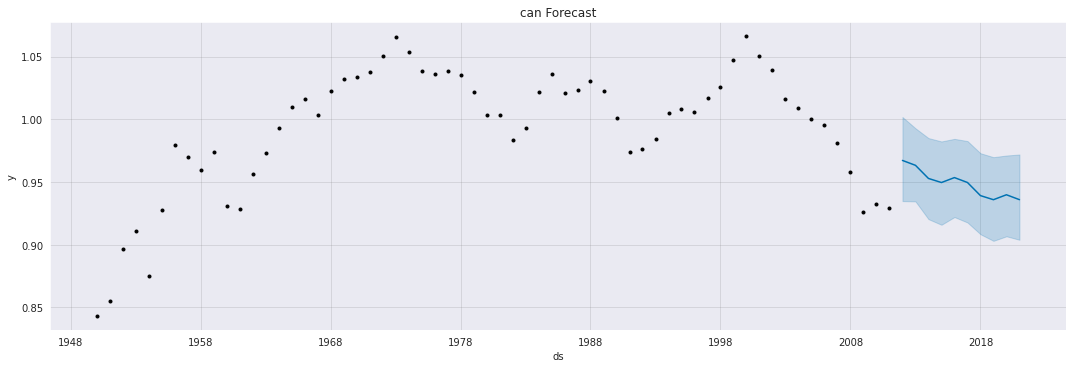

In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(can.reset_index().rename(columns={'year':'ds', 'rtfpna':'y'}))
can_fcst = pd.DataFrame(range(2012, 2022), columns=["ds"])
# Predict on training set with model
can_fcst = model.predict(df=can_fcst)
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(can_fcst,
                 ax=ax)
plt.title("can Forecast")
plt.show()

In [ ]:
can_fcst[["ds", "yhat"]]

,ds,yhat
0,2012-01-01,0.967215
1,2013-01-01,0.963305
2,2014-01-01,0.952849
3,2015-01-01,0.949591
4,2016-01-01,0.953530
5,2017-01-01,0.949621
6,2018-01-01,0.939165
7,2019-01-01,0.935906
8,2020-01-01,0.939846
9,2021-01-01,0.935937


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


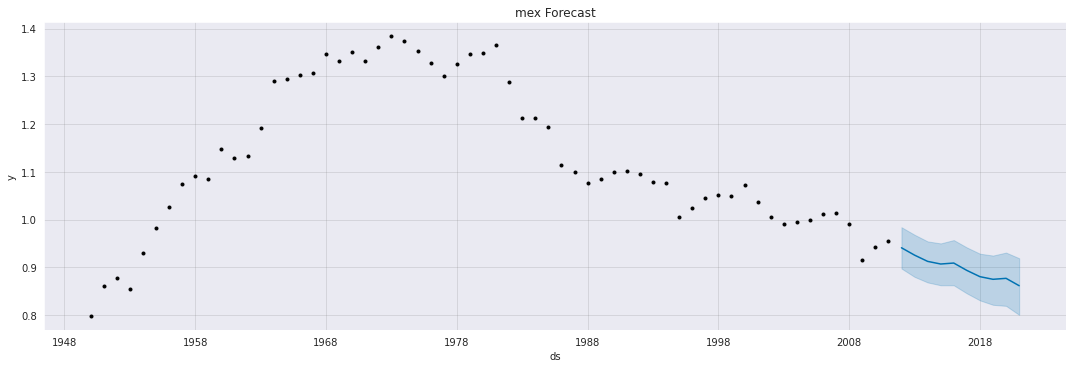

In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(mex.reset_index().rename(columns={'year':'ds', 'rtfpna':'y'}))
mex_fcst = pd.DataFrame(range(2012, 2022), columns=["ds"])
# Predict on training set with model
mex_fcst = model.predict(df=mex_fcst)
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(mex_fcst,
                 ax=ax)
plt.title("mex Forecast")
plt.show()

In [ ]:
mex_fcst[["ds", "yhat"]]

,ds,yhat
0,2012-01-01,0.940789
1,2013-01-01,0.925339
2,2014-01-01,0.912259
3,2015-01-01,0.906730
4,2016-01-01,0.908752
5,2017-01-01,0.893302
6,2018-01-01,0.880222
7,2019-01-01,0.874692
8,2020-01-01,0.876714
9,2021-01-01,0.861264
